In [1]:
# download and upload the data to the drive into a folder named ML assignments
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train_dir = "/content/drive/MyDrive/ML assignments/Dataset/Training"
val_dir = "/content/drive/MyDrive/ML assignments/Dataset/Validation"
test_dir = "/content/drive/MyDrive/ML assignments/Dataset/Testing"

In [3]:
# install necessary libraries if needed
!pip install scikeras
!pip install keras

In [4]:
# import libaries
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [5]:
# Function to count samples in each folder
def count_samples(folder):
    covid_path = os.path.join(folder, 'COVID')
    normal_path = os.path.join(folder, 'Normal')
    num_covid = len(os.listdir(covid_path))
    num_normal = len(os.listdir(normal_path))
    return num_covid, num_normal

# count samples in each folder
train_covid, train_normal = count_samples(train_dir)
test_covid, test_normal = count_samples(test_dir)
val_covid, val_normal = count_samples(val_dir)

# output the counts
print("Number of samples in each folder:")
print("Number of samples in each folder:")
print("Training - COVID:", train_covid)
print("Training - Normal:", train_normal)
print("Validation - COVID:", val_covid)
print("Validation - Normal:", val_normal)
print("Testing - COVID:", test_covid)
print("Testing - Normal:", test_normal)

Number of samples in each folder:
Number of samples in each folder:
Training - COVID: 200
Training - Normal: 200
Validation - COVID: 50
Validation - Normal: 50
Testing - COVID: 25
Testing - Normal: 25



Visualizing 2 COVID images from Training folder:


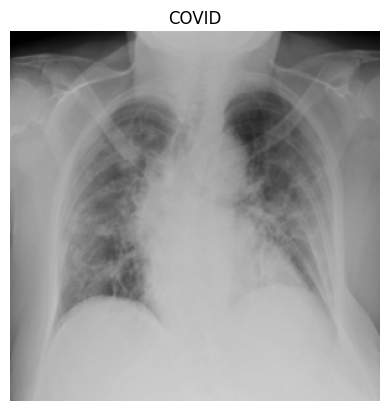

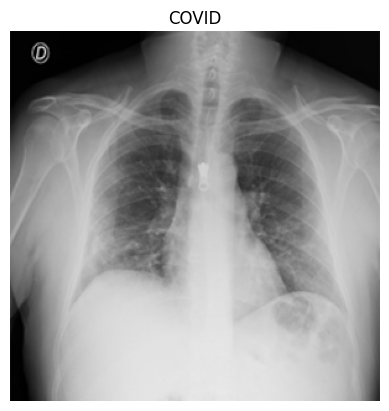


Visualizing 2 Normal images from Training folder:


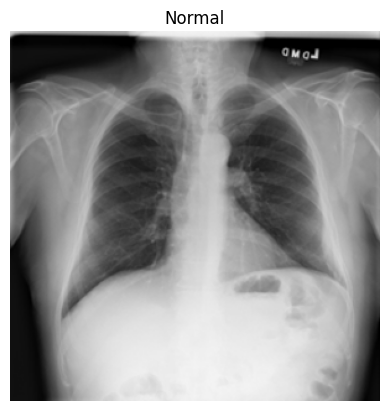

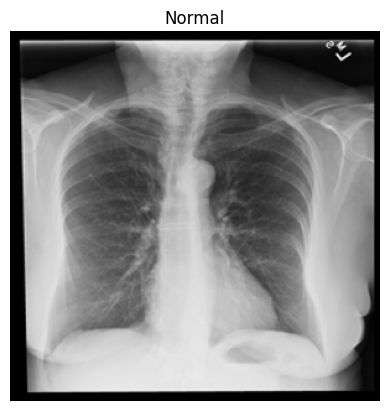


Visualizing 2 COVID images from Testing folder:


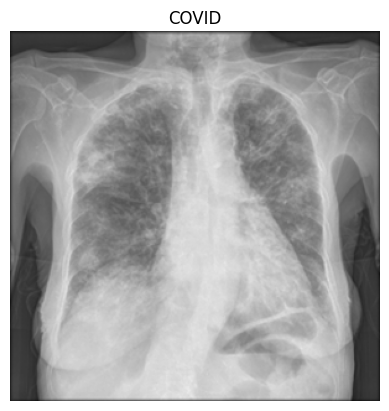

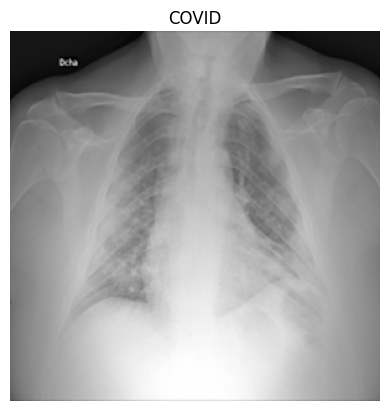


Visualizing 2 Normal images from Testing folder:


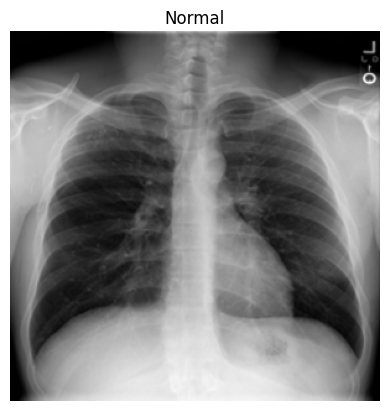

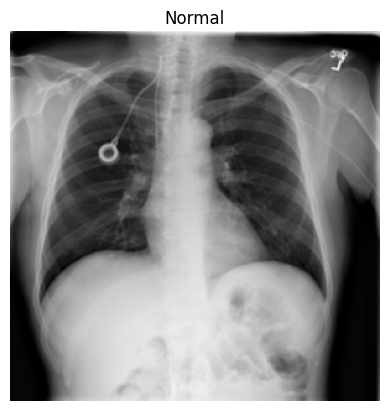


Visualizing 2 COVID images from Validation folder:


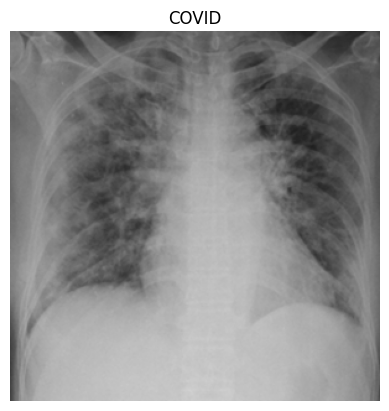

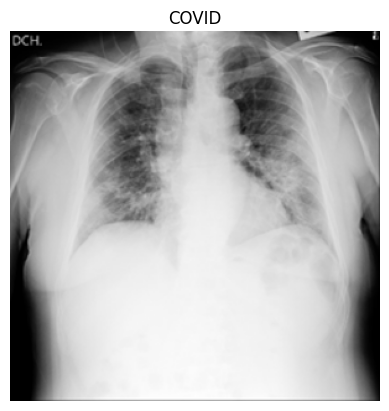


Visualizing 2 Normal images from Validation folder:


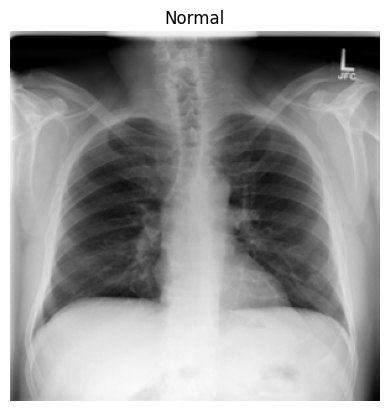

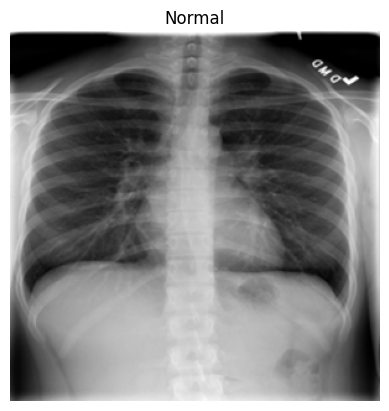

In [6]:
# function to visualize images from each folder
def visualize_images(folder, label, num_samples=2):
    covid_path = os.path.join(folder, 'COVID')
    normal_path = os.path.join(folder, 'Normal')

    # visualize COVID images
    covid_images = os.listdir(covid_path)[:num_samples]
    print(f"\nVisualizing {num_samples} COVID images from {label} folder:")
    for img_name in covid_images:
        img_path = os.path.join(covid_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title("COVID")
        plt.axis('off')
        plt.show()

    # visualize Normal images
    normal_images = os.listdir(normal_path)[:num_samples]
    print(f"\nVisualizing {num_samples} Normal images from {label} folder:")
    for img_name in normal_images:
        img_path = os.path.join(normal_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title("Normal")
        plt.axis('off')
        plt.show()

# visualize images from each folder
visualize_images(train_dir, "Training")
visualize_images(test_dir, "Testing")
visualize_images(val_dir, "Validation")

In [7]:
def load_images_from_folder(folder_path, label, target_size=(100, 100)):
    images = []
    labels = []
    label_dict = {'COVID': 0, 'Normal': 1}  # Define a dictionary to map labels to numeric values
    label_code = label_dict[label]

    label_path = os.path.join(folder_path, label)
    for img_name in os.listdir(label_path):
        img_path = os.path.join(label_path, img_name)
        # load the image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale
        # resize the image
        img_resized = cv2.resize(img, target_size)  # Resize the image to the specified target size
        # preprocess the resized image (e.g., normalize pixel values)
        img_resized = img_resized.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
        # flatten the resized image
        img_flat = img_resized.flatten()
        # append the flattened image and corresponding label
        images.append(img_flat)
        labels.append(label_code)
    return np.array(images), np.array(labels)

In [8]:
# load images from the training folder for both COVID and Normal labels
train_covid_images, train_covid_labels = load_images_from_folder(train_dir, 'COVID')
train_normal_images, train_normal_labels = load_images_from_folder(train_dir, 'Normal')

# load images from the testing folder for both COVID and Normal labels
test_covid_images, test_covid_labels = load_images_from_folder(test_dir, 'COVID')
test_normal_images, test_normal_labels = load_images_from_folder(test_dir, 'Normal')

# load images from the validation folder for both COVID and Normal labels
val_covid_images, val_covid_labels = load_images_from_folder(val_dir, 'COVID')
val_normal_images, val_normal_labels = load_images_from_folder(val_dir, 'Normal')

In [9]:
train_covid_images.shape

(200, 10000)

In [10]:
# combine COVID and Normal images and labels for training, validation and test
train_images = np.concatenate((train_covid_images, train_normal_images), axis=0)
train_labels = np.concatenate((train_covid_labels, train_normal_labels), axis=0)

val_images = np.concatenate((val_covid_images, val_normal_images), axis=0)
val_labels = np.concatenate((val_covid_labels, val_normal_labels), axis=0)

test_images = np.concatenate((test_covid_images, test_normal_images), axis=0)
test_labels = np.concatenate((test_covid_labels, test_normal_labels), axis=0)

In [11]:
results = [] # Array used to store tuples of (model, accuracy_score)

In [12]:
def plot_learning_curves(model, x_train, y_train, x_val, y_val):
    train_sizes, train_scores, val_scores = learning_curve(model, x_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curves")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

In [13]:
##### YOUR CODE STARTS HERE #####
# for more info about the model
# refer to https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

# initialize and train the decision tree classifier model
dt_model = DecisionTreeClassifier()

# train the model
dt_model.fit(train_images, train_labels)

# predict labels for the validation set
val_pred = dt_model.predict(val_images)

# report the validation accuracy of the trained model
val_accuracy = accuracy_score(val_labels, val_pred)

##### YOUR CODE ENDS HERE #####
print(f"Validation accuracy: {val_accuracy:.4f}")

Validation accuracy: 0.8900


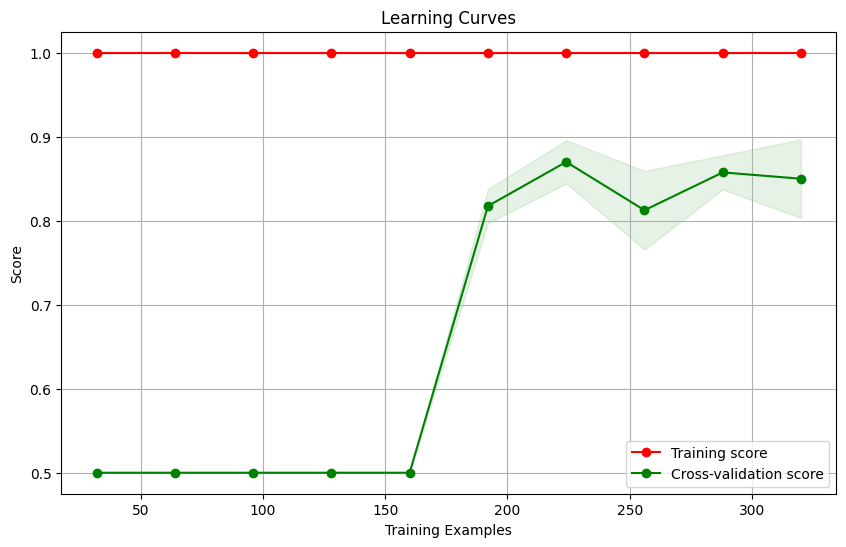

In [14]:
##### YOUR CODE STARTS HERE #####

# pass the appropriate parameters to the previously defined function plot_learning_curves()
plot_learning_curves(dt_model, train_images, train_labels, val_images, val_labels)

##### YOUR CODE ENDS HERE #####

Does your model suffer from overfitting (high variance) or underfitting (high bias) or neither and why?  
The model appears to be overfitting. The training score increases consistently, indicating that it learns the training data effectively. However, the cross-validation score starts lower and levels off around 0.85. This suggests that while the model improves in fitting the training data, it doesn’t perform significantly better on new, unseen data. The widening gap between the training and validation scores indicates high variance, meaning the model is likely too complex and is picking up on noise rather than general patterns.

In [15]:
##### YOUR CODE STARTS HERE #####

# define your parameters
param_grid = {
   'max_depth': [None, 5, 10, 15, 20],
   'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
   'criterion': ['gini', 'entropy']
}

# initialize the grid search
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy')

# fit the model
grid_search.fit(train_images, train_labels)

##### YOUR CODE ENDS HERE #####

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

##### YOUR CODE STARTS HERE #####

# Evaluate the best model on the validation set
# get the best model
best_model = grid_search.best_estimator_

# predict labels for the validation set
val_pred = best_model.predict(val_images)

# report the validation accuracy of the trained model
val_accuracy = accuracy_score(val_labels, val_pred)

##### YOUR CODE ENDS HERE #####

print(f"Validation accuracy with best model: {val_accuracy:.4f}")
results.append((best_model, val_accuracy))

Best parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best cross-validation score: 0.865
Validation accuracy with best model: 0.8600


In [16]:
##### YOUR CODE STARTS HERE #####

# initialize and train the Support Vector Machines model, use a linear kernel
svm_model = SVC(kernel='linear')
svm_model.fit(train_images, train_labels)

# train the model using training data
svm_model.fit(train_images, train_labels)

# report the number of support vectors
print("Number of support vectors:", len(svm_model.support_))

# predict labels for the validation set
val_pred = svm_model.predict(val_images)

# report the validation accuracy of the trained model
val_accuracy = accuracy_score(val_labels, val_pred)
print(f"Validation accuracy: {val_accuracy:.4f}")

##### YOUR CODE ENDS HERE #####

Number of support vectors: 77
Validation accuracy: 0.9500


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 199, in fit
    y = self._validate_targets(y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/

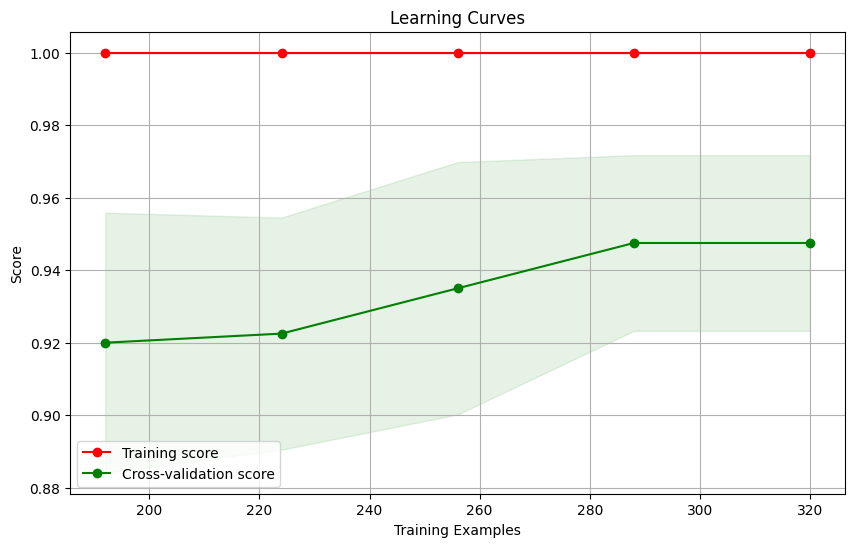

In [17]:
##### YOUR CODE STARTS HERE #####

# Pass the appropriate parameters to the previously defined function plot_learning_curves()
plot_learning_curves(svm_model, train_images, train_labels, val_images, val_labels)

##### YOUR CODE ENDS HERE #####

Does your model suffer from overfitting (high variance) or underfitting (high bias) or neither and why?

The model appears to be in a good place—not suffering from overfitting or underfitting. The training score increases steadily from around 150 to 320, reaching about 0.95, which shows that it's learning well from the training data. Meanwhile, the cross-validation score starts at 0.92 and climbs to 0.948, indicating strong performance on unseen data as well. The fact that the training and validation scores are closely aligned suggests a nice balance, meaning the model is capturing the important patterns without becoming too complicated or too simple.

In [18]:
##### YOUR CODE STARTS HERE #####

# define your parameters
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]  # Only relevant for 'poly' kernel
}

# initialize the grid search
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')

# fit the model using the training data
grid_search.fit(train_images, train_labels)

##### YOUR CODE ENDS HERE #####

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

##### YOUR CODE STARTS HERE #####
# Evaluate the best model on the validation set
# get the best model
best_model = grid_search.best_estimator_

# predict labels for the validation set
val_pred = best_model.predict(val_images)

# report the validation accuracy of the trained model
val_accuracy = accuracy_score(val_labels, val_pred)

##### YOUR CODE ENDS HERE #####

print(f"Validation accuracy with best model: {val_accuracy:.4f}")
results.append((best_model, val_accuracy))

Best parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.96
Validation accuracy with best model: 0.9700


In [19]:
# install necessary libraries if needed
!pip install scikeras
!pip install keras

# import libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras.models import Sequential
from keras.layers import Flatten
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score

In [20]:
# function to create a dense model
def create_dense_model(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),  # Flatten the input images
        Dense(128, activation='relu'),  # First hidden layer with 128 units and ReLU activation
        Dense(64, activation='relu'),   # Second hidden layer with 64 units and ReLU activation
        Dense(1, activation='sigmoid')  # Output layer with 1 unit and sigmoid activation for binary classification
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# function to extract the dense model from the pipeline
def extract_model(pipeline):
    return pipeline.steps[-1][1]

# Create a pipeline for the dense model
dense_pipeline = Pipeline([
    ('flatten', FunctionTransformer(lambda x: x.reshape((x.shape[0], -1)))),
    ('dense', KerasClassifier(model=create_dense_model, input_shape=(10000,), epochs=10, batch_size=32))
])

##### YOUR CODE STARTS HERE #####

model = extract_model(dense_pipeline)

# train the model using training data
dense_pipeline.fit(train_images, train_labels)

# predict labels for the validation set
y_val_pred = dense_pipeline.predict(val_images)

# report the validation accuracy of the trained model
val_accuracy = accuracy_score(val_labels, y_val_pred)

##### YOUR CODE ENDS HERE #####
print(f"Validation Accuracy: {val_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5518 - loss: 1.3948
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8010 - loss: 0.4038
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9062 - loss: 0.2046
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9198 - loss: 0.2038
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9233 - loss: 0.1589
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9587 - loss: 0.1055
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9334 - loss: 0.1292
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9639 - loss: 0.0973
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9760 - loss: 0.0870
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9733 - loss: 0.0856
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Validation Accuracy: 0.9500


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2835
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 1.0000 - loss: 5.6682e-13
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 1.0000 - loss: 1.6193e-20
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 1.1849e-26
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 7.0040e-32
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 1.8828e-36
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 1.0000 - loss: 0.0000e+00
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9375 - loss: 0.3833
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 8.8292e-15
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 1.5637e-22
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 2.2002e-29
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 3.9336e-31 
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 3.3543e-36
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 1.5660e-37 
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0000e+00 
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0000e+00


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4583 - loss: 0.5838
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 3.0488e-10
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 1.2343e-14
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 8.5754e-19 
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 1.0194e-22
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 1.0636e-23
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 3.0807e-25
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 8.7353e-26
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 2.9341e-27
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 2.7756e-28
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 1.0000 - loss: 0.2165
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 6.0141e-18
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 5.4357e-25
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 1.4544e-28
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 5.4500e-32
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 1.1468e-35
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 1.2979e-36
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 1.1170e-37
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 1.0000 - loss: 9.3285e-39
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 9.2844e-39
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5861 - loss: 0.3880
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 5.9637e-10
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 2.0885e-14
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 3.6912e-17
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 1.8943e-19
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 1.9309e-19
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 7.4456e-21
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 5.4695e-21
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 2.0280e-21
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 3.5908e-21
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6707 - loss: 1.1866
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8484 - loss: 0.5249
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8488 - loss: 0.3381
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9148 - loss: 0.2266
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9219 - loss: 0.1506
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9830 - loss: 0.0824
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9619 - loss: 0.1156
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9551 - loss: 0.0935
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9640 - loss: 0.0858
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9629 - loss: 0.0997
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5876 - loss: 1.4670
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6860 - loss: 0.8776
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9089 - loss: 0.2697
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9407 - loss: 0.1676
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9404 - loss: 0.1751
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9608 - loss: 0.1263
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9601 - loss: 0.1264
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9867 - loss: 0.0746
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9668 - loss: 0.1112
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9523 - loss: 0.1455
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6145 - loss: 1.2239
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6195 - loss: 0.6715
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8952 - loss: 0.2765
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9067 - loss: 0.2221
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9169 - loss: 0.2005
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9313 - loss: 0.1766
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9286 - loss: 0.1509
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9562 - loss: 0.1096
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9526 - loss: 0.1184
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9542 - loss: 0.0960
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5281 - loss: 2.1796
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7149 - loss: 0.5007
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8390 - loss: 0.3388
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9053 - loss: 0.2339
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9170 - loss: 0.2003
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9290 - loss: 0.1702
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9195 - loss: 0.1844
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9393 - loss: 0.1542
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9617 - loss: 0.1139
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9506 - loss: 0.1263
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4546 - loss: 1.9229
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8023 - loss: 0.4316
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9038 - loss: 0.2820
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9195 - loss: 0.2391
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8622 - loss: 0.2616
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9029 - loss: 0.2246
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9225 - loss: 0.1859
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9424 - loss: 0.1340
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9554 - loss: 0.1277
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9472 - loss: 0.1379
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 0.9404
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.0665
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 1.5763e-05
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.8345e-08
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 1.7182e-10
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 2.2224e-12
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 4.9177e-14
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.6064e-15
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 7.2922e-17
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 4.4037e-18
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9792 - loss: 0.3235
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 3.6720e-13
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 2.2093e-20
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 1.0760e-25
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 2.8031e-30 
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 5.9517e-34
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 1.3178e-37
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0000e+00
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 0.2620
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 6.6857e-14
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.8327e-21 
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 5.8598e-27
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 7.8920e-30 
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.9064e-33
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 5.5031e-36
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 9.8172e-38
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0000e+00
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7083 - loss: 0.3315
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 7.5685e-14
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 5.3920e-22
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 4.9772e-27
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 3.4000e-29
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 8.0753e-31
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 1.8522e-31
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 1.8347e-31
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 7.3253e-33
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 1.4655e-33
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5861 - loss: 0.6350
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 5.8026e-15
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 8.9184e-20
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.8074e-26
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 5.3660e-27
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.0935e-29
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 4.1782e-30
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 4.4151e-30
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 6.1578e-31
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.3157e-31
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7354 - loss: 1.5533
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7849 - loss: 1.7711
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7147 - loss: 0.5145
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9358 - loss: 0.2145
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9130 - loss: 0.2071
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9482 - loss: 0.1337
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9576 - loss: 0.1285
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9669 - loss: 0.0839
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9746 - loss: 0.0891
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9585 - loss: 0.0916
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5306 - loss: 1.3957
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6599 - loss: 0.4870
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8704 - loss: 0.3447
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9439 - loss: 0.1835
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9715 - loss: 0.1301
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9702 - loss: 0.1017
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9623 - loss: 0.1022
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9702 - loss: 0.1214
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9713 - loss: 0.0938
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9875 - loss: 0.0724
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5748 - loss: 0.9045
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8786 - loss: 0.2801
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8935 - loss: 0.2741
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9306 - loss: 0.1882
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9384 - loss: 0.2015
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9121 - loss: 0.2068
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9286 - loss: 0.1722
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9234 - loss: 0.2240
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9574 - loss: 0.1143
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9703 - loss: 0.1003
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5127 - loss: 1.0437
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8429 - loss: 0.3416
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9370 - loss: 0.1929
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9161 - loss: 0.1607
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9375 - loss: 0.1355
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9449 - loss: 0.1284
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9456 - loss: 0.1106
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9550 - loss: 0.1283
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9266 - loss: 0.1628
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9520 - loss: 0.0981
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4991 - loss: 1.3211
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8809 - loss: 0.2690
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9343 - loss: 0.2098
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8655 - loss: 0.3087
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9222 - loss: 0.2247
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9121 - loss: 0.2351
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9524 - loss: 0.1113
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9650 - loss: 0.0975
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9712 - loss: 0.0774
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9613 - loss: 0.0892
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9688 - loss: 0.5497
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 2.9151e-07
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 3.5600e-11
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 2.3720e-14
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 4.5026e-17
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.8506e-19
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 1.4038e-21
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 1.7679e-23
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 3.4263e-25
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 9.6515e-27
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4583 - loss: 0.5067
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 1.3055e-08 
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 2.6653e-13
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 1.1056e-16 
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 6.1145e-20
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 6.0758e-23 
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 2.5209e-24 
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 1.9311e-26 
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 6.2560e-27
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 8.6975e-29
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 0.2367
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.9807e-20
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 9.6610e-27
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 6.0323e-35 
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0000e+00
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5333 - loss: 0.5358  
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.1360e-10
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.7783e-17
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 5.9790e-20
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 1.9976e-21
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 1.0438e-24
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.2197e-25
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 1.3996e-25
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.9736e-26
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 1.6741e-26
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 1.0000 - loss: 0.1689
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 8.2325e-27
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 2.8817e-34
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.0000e+00
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7361 - loss: 1.8336
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8467 - loss: 0.9934
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8478 - loss: 0.3467
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8766 - loss: 0.3057
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9391 - loss: 0.1577
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9589 - loss: 0.1571
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9336 - loss: 0.1744
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9599 - loss: 0.1260
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9651 - loss: 0.0816
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9740 - loss: 0.1036
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7592 - loss: 0.9363
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8768 - loss: 0.2712
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9286 - loss: 0.1625
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9626 - loss: 0.1219
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9594 - loss: 0.1273
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9710 - loss: 0.0938
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9433 - loss: 0.1272
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9150 - loss: 0.1760
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8896 - loss: 0.2309
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9211 - loss: 0.2114
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6276 - loss: 1.7535
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4770 - loss: 1.8798
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6987 - loss: 0.6616
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8967 - loss: 0.2520
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8815 - loss: 0.3476
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9097 - loss: 0.1849
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9316 - loss: 0.1896
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9001 - loss: 0.2078
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9287 - loss: 0.1472
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9071 - loss: 0.1812
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5390 - loss: 1.1922
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6836 - loss: 0.5268
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9155 - loss: 0.2830
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8848 - loss: 0.2333
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8756 - loss: 0.2531
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9216 - loss: 0.1796
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9057 - loss: 0.1943
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9360 - loss: 0.1556
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9406 - loss: 0.1249
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9448 - loss: 0.1768
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4623 - loss: 2.1820
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6211 - loss: 0.6183
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9061 - loss: 0.3524
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8875 - loss: 0.2892
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9162 - loss: 0.2585
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9196 - loss: 0.1971
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9024 - loss: 0.1862
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9386 - loss: 0.1686
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9308 - loss: 0.1714
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9484 - loss: 0.1485
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2866
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 1.5570e-09
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 4.0218e-15
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 1.1274e-19
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 1.4756e-23
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 5.9609e-27
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 5.8760e-30
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 1.1924e-32
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 4.4036e-35
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 2.7733e-37
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 1.0000 - loss: 0.3069
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 3.2592e-14
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 4.8361e-22
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 6.2918e-27 
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 7.4582e-31
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 1.4010e-34
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 1.6899e-38
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0000e+00
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4583 - loss: 0.5594  
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 4.1123e-13
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 2.1733e-18
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 6.0713e-24 
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 5.8234e-27
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 3.0776e-28 
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 2.2407e-31
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.6431e-31
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 1.1371e-33
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 1.9853e-33
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 1.0000 - loss: 0.2376
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 1.2675e-13
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 2.8894e-20
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 3.6120e-26
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 6.1770e-29
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 5.0040e-30
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 5.9403e-31
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 1.5013e-32
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 2.9974e-33
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 2.1024e-33
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9871 - loss: 0.2393
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 3.7636e-31
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.0000e+00
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5668 - loss: 1.4431
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8107 - loss: 0.6990
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8604 - loss: 0.4141
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8472 - loss: 0.3229
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9305 - loss: 0.1702
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9336 - loss: 0.1720
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9453 - loss: 0.1291
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9586 - loss: 0.1238
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9562 - loss: 0.1164
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9417 - loss: 0.1266
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6680 - loss: 1.9998
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7519 - loss: 0.5778
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8438 - loss: 0.4153
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8610 - loss: 0.3490
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8632 - loss: 0.2984
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9014 - loss: 0.2200
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9260 - loss: 0.2261
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9544 - loss: 0.1467
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9580 - loss: 0.1050
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9749 - loss: 0.1114
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5567 - loss: 1.5564
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8515 - loss: 0.3587
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9589 - loss: 0.1822
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9181 - loss: 0.1771
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9361 - loss: 0.2024
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9352 - loss: 0.1309
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9378 - loss: 0.1525
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9455 - loss: 0.1456
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9487 - loss: 0.1732
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9302 - loss: 0.1534
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6468 - loss: 0.9530
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7214 - loss: 0.6084
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8502 - loss: 0.4457
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8958 - loss: 0.2763
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9458 - loss: 0.1556
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9188 - loss: 0.1431
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9466 - loss: 0.1172
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9663 - loss: 0.1091
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9634 - loss: 0.0864
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9478 - loss: 0.1104
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5234 - loss: 1.3738
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8745 - loss: 0.3451
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8778 - loss: 0.2879
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8843 - loss: 0.2846
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9537 - loss: 0.1242
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9374 - loss: 0.1454
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9506 - loss: 0.1050
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9083 - loss: 0.2385
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9445 - loss: 0.1307
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9519 - loss: 0.1307
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6875 - loss: 0.6488
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.6691e-06
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 5.5101e-10
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 5.2498e-13
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 1.3223e-15
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 6.7737e-18
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 6.0746e-20
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 8.7274e-22
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 1.8711e-23
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 5.7032e-25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3333 - loss: 0.6965  
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 1.0885e-13 
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 2.3994e-20
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 5.8173e-26 
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 1.1171e-30
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 3.0002e-35 
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0000e+00
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4583 - loss: 0.8649  
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.2446e-10
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 4.5024e-17
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 9.2243e-21 
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 2.1013e-22
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 1.4023e-24
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.3476e-27
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 3.9561e-28
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 4.7864e-29 
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 3.7536e-30 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5333 - loss: 0.9226
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.9018e-12
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.5467e-18
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 2.1615e-22
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 3.3782e-24
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 8.7452e-27
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 1.7880e-28
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 2.8243e-29
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 7.5827e-30
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 1.8520e-30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5861 - loss: 0.3677
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 1.5142e-21
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 2.2316e-29
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 2.6995e-36
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 1.4755e-37
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 2.6070e-38
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0000e+00
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5688 - loss: 0.8393
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8621 - loss: 0.3947
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8243 - loss: 0.3960
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8974 - loss: 0.2079
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9756 - loss: 0.1474
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9338 - loss: 0.1512
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9649 - loss: 0.1142
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9702 - loss: 0.0960
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9641 - loss: 0.0881
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9749 - loss: 0.0770
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5189 - loss: 1.1146
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7144 - loss: 0.7503
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7956 - loss: 0.4010
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8616 - loss: 0.2994
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9052 - loss: 0.2372
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9515 - loss: 0.1783
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9568 - loss: 0.1435
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9562 - loss: 0.1465
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9704 - loss: 0.1167
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9625 - loss: 0.1225
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5620 - loss: 1.2687
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7487 - loss: 0.5068
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8866 - loss: 0.2863
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9195 - loss: 0.1956
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9170 - loss: 0.1954
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9061 - loss: 0.2103
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9037 - loss: 0.2297
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9718 - loss: 0.1016
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9546 - loss: 0.1214
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9469 - loss: 0.1225
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5360 - loss: 1.3903
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8298 - loss: 0.3667
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8859 - loss: 0.2401
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8930 - loss: 0.2642
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9010 - loss: 0.2295
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9355 - loss: 0.1367
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9658 - loss: 0.1222
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9508 - loss: 0.1376
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9648 - loss: 0.1018
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9518 - loss: 0.1254
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5347 - loss: 1.7161
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6341 - loss: 0.6405
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8923 - loss: 0.3007
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9057 - loss: 0.2452
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9153 - loss: 0.1906
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9164 - loss: 0.1945
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9422 - loss: 0.1558
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9428 - loss: 0.1360
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9454 - loss: 0.1397
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9653 - loss: 0.1037
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


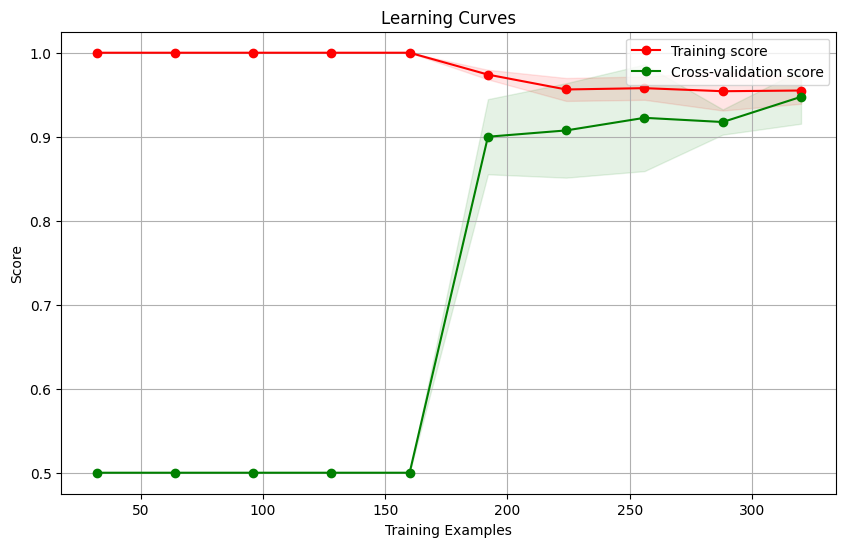

In [21]:
##### YOUR CODE STARTS HERE #####

# pass the appropriate parameters to the previously defined function plot_learning_curves()
plot_learning_curves(dense_pipeline, train_images, train_labels, val_images, val_labels)

##### YOUR CODE ENDS HERE #####

Does your model suffer from overfitting (high variance) or underfitting (high bias) or neither and why?  The learning curve indicates that the model isn't strongly overfitting or underfitting, though there are minor fluctuations in performance. The training score starts at 1.0 but slightly decreases with more examples, suggesting the model may not fit the training data perfectly. Meanwhile, the cross-validation score steadily improves, stabilizing around 0.9, which reflects good generalization to unseen data. Overall, the model shows strong performance and generalization, with any slight declines in training scores likely due to the training process rather than clear overfitting or underfitting.

In [22]:
##### YOUR CODE STARTS HERE #####

from sklearn.model_selection import RandomizedSearchCV

# define the parameter space
# define the parameter grid to search
param_dist = {
    'dense__optimizer': ['adam', 'sgd'],
    'dense__batch_size': [16, 32, 64],
    'dense__epochs': [10, 20, 30]
}
# initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=dense_pipeline,
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   cv=5,)


# fit RandomizedSearchCV
random_search.fit(train_images, train_labels)

##### YOUR CODE ENDS HERE #####

# print the best parameters found
print("Best Parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

##### YOUR CODE STARTS HERE #####
# evaluate the best model on the validation set
# get the best model
best_model = random_search.best_estimator_

# predict labels for the validation set
val_pred = best_model.predict(val_images)

# report the validation accuracy of the trained model
val_accuracy = accuracy_score(val_labels, val_pred)

##### YOUR CODE ENDS HERE #####

print(f"Validation accuracy with best model: {val_accuracy:.4f}")
results.append((best_model, val_accuracy))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6477 - loss: 0.7968
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9224 - loss: 0.1609
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9154 - loss: 0.2040
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9364 - loss: 0.1551
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9300 - loss: 0.1388
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9271 - loss: 0.1668
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9409 - loss: 0.1728
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9607 - loss: 0.0955
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9439 - loss: 0.1387
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9048 - loss: 0.1778
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5079 - loss: 2.0158
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7768 - loss: 0.5057
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8987 - loss: 0.3096
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9607 - loss: 0.1062
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9309 - loss: 0.1594
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9386 - loss: 0.1400
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9453 - loss: 0.1177
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9613 - loss: 0.0861
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9319 - loss: 0.1383
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9638 - loss: 0.1012
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5838 - loss: 1.7532
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8960 - loss: 0.2903
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9051 - loss: 0.2474
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9033 - loss: 0.1970
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9453 - loss: 0.1558
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9545 - loss: 0.1190
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9476 - loss: 0.1109
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9448 - loss: 0.1633
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9372 - loss: 0.1802
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9676 - loss: 0.0937
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6737 - loss: 0.9325
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9504 - loss: 0.1203
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9685 - loss: 0.1039
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9426 - loss: 0.1097
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8716 - loss: 0.3945
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9233 - loss: 0.1562
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9305 - loss: 0.1501
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9186 - loss: 0.1760
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9575 - loss: 0.0847
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9764 - loss: 0.0787
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6424 - loss: 1.0439
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8856 - loss: 0.2421
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9372 - loss: 0.1317
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9024 - loss: 0.2141
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9382 - loss: 0.1712
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8003 - loss: 0.6419
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9246 - loss: 0.1865
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9604 - loss: 0.0878
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9568 - loss: 0.1705
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8892 - loss: 0.2803
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6233 - loss: 0.9788
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9150 - loss: 0.2210
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9324 - loss: 0.1746
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9100 - loss: 0.2232
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9397 - loss: 0.1431
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9492 - loss: 0.1419
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9182 - loss: 0.1566
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9729 - loss: 0.0659
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9316 - loss: 0.1443
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8897 - loss: 0.3679
Epoch 11/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9638 - loss: 0.0897
Epoch 12/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9451 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6233 - loss: 1.5886
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9291 - loss: 0.2046
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9470 - loss: 0.1384
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9358 - loss: 0.1632
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9670 - loss: 0.0968
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9321 - loss: 0.1132
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9744 - loss: 0.0880
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9011 - loss: 0.2707
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9302 - loss: 0.1939
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9471 - loss: 0.1188
Epoch 11/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9506 - loss: 0.1033
Epoch 12/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9897 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5859 - loss: 1.8282
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8830 - loss: 0.2656
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9088 - loss: 0.1844
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9076 - loss: 0.2264
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9067 - loss: 0.1760
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9097 - loss: 0.1774
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9668 - loss: 0.0820
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9784 - loss: 0.0895
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9809 - loss: 0.0704
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9163 - loss: 0.1786
Epoch 11/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9446 - loss: 0.1076
Epoch 12/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9385 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5683 - loss: 1.2464
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8704 - loss: 0.2817
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9177 - loss: 0.1743
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8652 - loss: 0.3288
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8939 - loss: 0.2204
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9789 - loss: 0.0851
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9821 - loss: 0.0786
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9336 - loss: 0.1553
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8167 - loss: 0.4525
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9120 - loss: 0.2738
Epoch 11/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9701 - loss: 0.1298
Epoch 12/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9690 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5126 - loss: 1.6787
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7710 - loss: 0.5028
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8886 - loss: 0.2642
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8890 - loss: 0.2398
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9085 - loss: 0.2081
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9157 - loss: 0.2339
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9193 - loss: 0.1916
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9142 - loss: 0.1578
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9210 - loss: 0.1501
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9229 - loss: 0.1468
Epoch 11/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9526 - loss: 0.1152
Epoch 12/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9538 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5179 - loss: 1.6958
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5160 - loss: 0.8998
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8280 - loss: 0.3595
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8605 - loss: 0.3631
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9128 - loss: 0.2408
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8768 - loss: 0.2204
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9095 - loss: 0.2403
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9398 - loss: 0.1459
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9495 - loss: 0.1539
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9485 - loss: 0.1172
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9512 - loss: 0.1204
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9653 - loss: 0.1086
Epoch 13/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5248 - loss: 1.5128
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6798 - loss: 0.6732
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8710 - loss: 0.2988
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9184 - loss: 0.2388
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9181 - loss: 0.2008
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9255 - loss: 0.1905
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8836 - loss: 0.2397
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9384 - loss: 0.1423
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9576 - loss: 0.1140
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9328 - loss: 0.1209
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9592 - loss: 0.0929
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9374 - loss: 0.1165
Epoch 13/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5112 - loss: 1.6199
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5198 - loss: 1.6923
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6997 - loss: 0.6508
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7681 - loss: 0.4948
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8791 - loss: 0.3044
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9128 - loss: 0.2343
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9116 - loss: 0.2035
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9038 - loss: 0.1895
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9239 - loss: 0.1572
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9103 - loss: 0.1797
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9307 - loss: 0.1679
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9439 - loss: 0.1465
Epoch 13/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5616 - loss: 1.5048
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6751 - loss: 0.9068
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8776 - loss: 0.3029
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9059 - loss: 0.2138
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9273 - loss: 0.1874
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9480 - loss: 0.1517
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9436 - loss: 0.1627
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9071 - loss: 0.1965
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9470 - loss: 0.1366
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9422 - loss: 0.1498
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9126 - loss: 0.1722
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9464 - loss: 0.1335
Epoch 13/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5025 - loss: 1.5634
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5692 - loss: 0.8833
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6886 - loss: 0.5205
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8921 - loss: 0.3365
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9077 - loss: 0.2678
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9080 - loss: 0.2275
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9118 - loss: 0.2244
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9118 - loss: 0.2036
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9181 - loss: 0.1895
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9522 - loss: 0.1459
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9393 - loss: 0.1390
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9168 - loss: 0.1873
Epoch 13/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4575 - loss: 1.7886
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7974 - loss: 0.4716
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8671 - loss: 0.3570
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8741 - loss: 0.3170
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8944 - loss: 0.2679
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8863 - loss: 0.2231
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9466 - loss: 0.1536
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9526 - loss: 0.1384
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9417 - loss: 0.1301
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9422 - loss: 0.1420
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9434 - loss: 0.1259
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9490 - loss: 0.1278
Epoch 13/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5189 - loss: 1.4144
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5242 - loss: 1.1309
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7326 - loss: 0.4713
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8349 - loss: 0.3919
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8964 - loss: 0.2594
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9092 - loss: 0.2181
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9291 - loss: 0.1574
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9414 - loss: 0.1414
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9303 - loss: 0.1440
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9372 - loss: 0.1799
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9343 - loss: 0.1368
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9351 - loss: 0.1537
Epoch 13/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4605 - loss: 1.5566
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5759 - loss: 1.1799
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7948 - loss: 0.4508
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8743 - loss: 0.2908
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9121 - loss: 0.1860
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9444 - loss: 0.1519
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9187 - loss: 0.1697
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9023 - loss: 0.2247
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9065 - loss: 0.1889
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9326 - loss: 0.1740
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9209 - loss: 0.2122
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9518 - loss: 0.1451
Epoch 13/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5355 - loss: 1.6975
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6099 - loss: 1.4609
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6448 - loss: 0.8324
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8417 - loss: 0.3464
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9086 - loss: 0.2044
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9222 - loss: 0.2055
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9230 - loss: 0.1885
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9419 - loss: 0.1274
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9388 - loss: 0.1794
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9415 - loss: 0.1434
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9591 - loss: 0.1188
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9626 - loss: 0.1070
Epoch 13/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4997 - loss: 1.7431
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6125 - loss: 1.1150
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7110 - loss: 0.5307
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8945 - loss: 0.2978
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8984 - loss: 0.2659
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9123 - loss: 0.2242
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8888 - loss: 0.2449
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9046 - loss: 0.2093
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9197 - loss: 0.1679
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9468 - loss: 0.1406
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9623 - loss: 0.1210
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9587 - loss: 0.1183
Epoch 13/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6381 - loss: 1.0815
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8745 - loss: 0.3316
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9176 - loss: 0.1878
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9081 - loss: 0.2459
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9408 - loss: 0.1427
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9279 - loss: 0.1545
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9518 - loss: 0.0955
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9710 - loss: 0.0774
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9601 - loss: 0.0891
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9776 - loss: 0.0631
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9463 - loss: 0.1460
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8977 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5553 - loss: 1.1333
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8755 - loss: 0.3149
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8892 - loss: 0.2266
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8917 - loss: 0.2129
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9305 - loss: 0.1604
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9553 - loss: 0.1125
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9636 - loss: 0.0909
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9499 - loss: 0.1325
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9606 - loss: 0.0978
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9168 - loss: 0.1777
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9224 - loss: 0.1855
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9767 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5577 - loss: 1.8131
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8433 - loss: 0.3873
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9258 - loss: 0.1943
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9201 - loss: 0.1825
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9241 - loss: 0.1828
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9167 - loss: 0.1864
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9184 - loss: 0.1843
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8822 - loss: 0.2880
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9411 - loss: 0.1294
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9670 - loss: 0.0979
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9422 - loss: 0.1566
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9509 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5721 - loss: 1.3565
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8308 - loss: 0.3441
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9491 - loss: 0.1518
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9488 - loss: 0.1544
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8983 - loss: 0.2261
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9596 - loss: 0.1077
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9216 - loss: 0.2053
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8611 - loss: 0.3467
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9438 - loss: 0.1881
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9654 - loss: 0.0925
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9511 - loss: 0.1143
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9712 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5652 - loss: 1.1218
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8580 - loss: 0.2961
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9254 - loss: 0.1776
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9184 - loss: 0.2189
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9492 - loss: 0.1476
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9224 - loss: 0.1864
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9569 - loss: 0.1275
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9327 - loss: 0.1436
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9508 - loss: 0.1090
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9663 - loss: 0.0861
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9706 - loss: 0.0823
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9651 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5509 - loss: 1.2406
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8509 - loss: 0.3475
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9162 - loss: 0.1643
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8663 - loss: 0.3042
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9435 - loss: 0.1152
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9506 - loss: 0.1190
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9355 - loss: 0.1477
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9649 - loss: 0.0922
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9506 - loss: 0.1220
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9483 - loss: 0.1072
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9585 - loss: 0.0916
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9251 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5056 - loss: 1.9626
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8969 - loss: 0.2602
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9132 - loss: 0.1999
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9599 - loss: 0.1053
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9764 - loss: 0.1004
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9258 - loss: 0.1721
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9394 - loss: 0.1299
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9498 - loss: 0.1352
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9780 - loss: 0.0567
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9775 - loss: 0.0809
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9690 - loss: 0.0904
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9728 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6222 - loss: 1.1675
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8392 - loss: 0.4517
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9203 - loss: 0.1804
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9042 - loss: 0.2334
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9305 - loss: 0.1252
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8866 - loss: 0.2891
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9496 - loss: 0.1386
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9629 - loss: 0.0984
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9639 - loss: 0.0994
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9367 - loss: 0.1057
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9193 - loss: 0.1718
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9569 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6229 - loss: 1.2816
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8976 - loss: 0.2172
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9253 - loss: 0.1925
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9188 - loss: 0.2230
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9543 - loss: 0.1248
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9206 - loss: 0.1865
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9644 - loss: 0.0831
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9338 - loss: 0.1836
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9732 - loss: 0.0836
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9607 - loss: 0.1172
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9694 - loss: 0.0925
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9421 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6238 - loss: 1.2557
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8699 - loss: 0.2650
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9222 - loss: 0.1765
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9121 - loss: 0.1776
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8169 - loss: 0.4072
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9465 - loss: 0.1389
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9629 - loss: 0.0930
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9361 - loss: 0.1754
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8789 - loss: 0.2600
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9102 - loss: 0.2124
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9310 - loss: 0.1496
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9596 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4956 - loss: 1.5778
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6165 - loss: 0.7549
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6649 - loss: 0.5879
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9148 - loss: 0.2607
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8653 - loss: 0.2794
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8833 - loss: 0.3189
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8890 - loss: 0.2639
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9088 - loss: 0.2185
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9161 - loss: 0.1998
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9445 - loss: 0.1550
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4824 - loss: 2.2887
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5693 - loss: 0.8801
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6774 - loss: 0.6105
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7134 - loss: 0.5228
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8275 - loss: 0.3587
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8911 - loss: 0.2561
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9260 - loss: 0.1972
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9279 - loss: 0.1787
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9199 - loss: 0.1588
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9334 - loss: 0.1458
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4832 - loss: 1.8604
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6460 - loss: 0.6069
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8501 - loss: 0.3638
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9111 - loss: 0.2519
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9058 - loss: 0.2093
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9313 - loss: 0.1712
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9243 - loss: 0.1419
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9365 - loss: 0.1326
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9282 - loss: 0.1494
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9544 - loss: 0.1138
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5397 - loss: 1.5990
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6931 - loss: 0.6738
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8397 - loss: 0.3528
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8885 - loss: 0.2949
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9320 - loss: 0.1839
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9252 - loss: 0.1760
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9375 - loss: 0.1504
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9521 - loss: 0.1299
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9235 - loss: 0.1654
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9387 - loss: 0.1383
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5605 - loss: 2.9673
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5492 - loss: 1.0751
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8007 - loss: 0.4525
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8684 - loss: 0.3147
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9010 - loss: 0.2567
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8925 - loss: 0.2241
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9201 - loss: 0.1891
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9145 - loss: 0.1783
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9244 - loss: 0.1532
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9323 - loss: 0.1562
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4994 - loss: 1.3183
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7398 - loss: 0.5907
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9021 - loss: 0.2893
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9058 - loss: 0.2606
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9195 - loss: 0.1906
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9315 - loss: 0.1850
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9313 - loss: 0.1665
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9234 - loss: 0.1520
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9326 - loss: 0.1973
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9601 - loss: 0.1097
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5352 - loss: 1.2053
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5847 - loss: 0.6924
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9189 - loss: 0.2887
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8967 - loss: 0.2425
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9109 - loss: 0.2076
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9265 - loss: 0.1600
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9439 - loss: 0.1346
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9322 - loss: 0.1339
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9616 - loss: 0.1154
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9295 - loss: 0.1701
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4963 - loss: 2.0957
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5639 - loss: 1.0422
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7331 - loss: 0.4784
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8351 - loss: 0.3679
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8653 - loss: 0.3246
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9019 - loss: 0.2399
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9138 - loss: 0.1851
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9197 - loss: 0.1877
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9208 - loss: 0.1674
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9179 - loss: 0.1486
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5595 - loss: 1.4902
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8071 - loss: 0.4254
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9060 - loss: 0.2551
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9212 - loss: 0.2133
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9175 - loss: 0.2016
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9390 - loss: 0.1616
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9452 - loss: 0.1437
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9381 - loss: 0.1467
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9491 - loss: 0.1320
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9375 - loss: 0.1477
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4695 - loss: 1.5258
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5771 - loss: 0.9912
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6960 - loss: 0.5405
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8704 - loss: 0.3226
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8870 - loss: 0.2644
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8925 - loss: 0.2215
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9158 - loss: 0.2011
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9321 - loss: 0.1710
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9364 - loss: 0.1866
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9217 - loss: 0.1620
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5532 - loss: 0.9225
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8535 - loss: 0.3247
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9390 - loss: 0.1662
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9055 - loss: 0.2027
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9380 - loss: 0.1489
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9151 - loss: 0.1927
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9321 - loss: 0.1246
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9169 - loss: 0.1818
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9737 - loss: 0.0789
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9454 - loss: 0.1156
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9414 - loss: 0.1377
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9702 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6224 - loss: 1.4795
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8828 - loss: 0.2404
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9177 - loss: 0.2009
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9548 - loss: 0.1735
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9310 - loss: 0.1694
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9016 - loss: 0.1861
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9586 - loss: 0.0892
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9227 - loss: 0.1624
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9739 - loss: 0.0953
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9789 - loss: 0.0716
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9766 - loss: 0.0652
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9642 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6861 - loss: 1.1696
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9298 - loss: 0.1964
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9419 - loss: 0.1691
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9426 - loss: 0.1280
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9153 - loss: 0.1960
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9139 - loss: 0.2170
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9631 - loss: 0.0950
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9774 - loss: 0.0795
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9278 - loss: 0.1279
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9411 - loss: 0.1510
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9352 - loss: 0.1546
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9389 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6362 - loss: 0.9789
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8351 - loss: 0.3702
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9253 - loss: 0.1803
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9332 - loss: 0.1692
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9296 - loss: 0.1440
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9428 - loss: 0.1307
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9637 - loss: 0.1109
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9296 - loss: 0.1430
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9249 - loss: 0.1862
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9511 - loss: 0.1462
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9598 - loss: 0.0974
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9858 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5901 - loss: 1.3672
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8796 - loss: 0.2908
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9058 - loss: 0.2203
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8774 - loss: 0.2904
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8608 - loss: 0.3337
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9061 - loss: 0.2647
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8980 - loss: 0.2118
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9265 - loss: 0.2100
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9622 - loss: 0.1031
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9535 - loss: 0.1092
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9627 - loss: 0.0714
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9388 - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6537 - loss: 0.8840
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8288 - loss: 0.3741
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8917 - loss: 0.2434
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9245 - loss: 0.1562
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9286 - loss: 0.1547
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9326 - loss: 0.1849
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8711 - loss: 0.3079
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8569 - loss: 0.3803
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8971 - loss: 0.2830
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9319 - loss: 0.1825
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4976 - loss: 2.3335
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6414 - loss: 0.7303
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7974 - loss: 0.4050
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8916 - loss: 0.2581
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8736 - loss: 0.3010
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9085 - loss: 0.2153
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9404 - loss: 0.1436
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9331 - loss: 0.1648
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9258 - loss: 0.1483
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9445 - loss: 0.1300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5413 - loss: 1.5618
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8222 - loss: 0.3900
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9069 - loss: 0.2086
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9193 - loss: 0.2028
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9371 - loss: 0.1540
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9156 - loss: 0.1593
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9609 - loss: 0.0973
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9580 - loss: 0.1076
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9551 - loss: 0.1064
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9191 - loss: 0.1913
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5687 - loss: 1.2759
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8937 - loss: 0.3191
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9297 - loss: 0.1992
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9237 - loss: 0.1833
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9309 - loss: 0.1704
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8915 - loss: 0.2505
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9213 - loss: 0.1986
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9333 - loss: 0.1790
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9560 - loss: 0.1129
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9564 - loss: 0.1057
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5668 - loss: 1.5454
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7537 - loss: 0.5200
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8661 - loss: 0.3426
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9219 - loss: 0.2001
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9307 - loss: 0.1794
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9352 - loss: 0.1783
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9306 - loss: 0.1578
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9623 - loss: 0.1343
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9534 - loss: 0.1363
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9415 - loss: 0.1319
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5272 - loss: 1.5625
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8606 - loss: 0.2862
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9440 - loss: 0.1509
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9468 - loss: 0.1554
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9404 - loss: 0.1640
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9349 - loss: 0.1597
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9397 - loss: 0.1347
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8853 - loss: 0.2750
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9174 - loss: 0.1739
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9488 - loss: 0.1253
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9509 - loss: 0.1086
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9583 - l

In [23]:
##### YOUR CODE STARTS HERE #####

# Find the best model based on the highest score
best = max(results, key=lambda x: x[1])

# find the best model
final_best_model = best[0]  # Retrieve the best model from the tuple
print("Best model:", final_best_model)

# Make predictions on the test set using the best model
test_pred = final_best_model.predict(test_images)

# Calculate the test accuracy
accuracy = accuracy_score(test_labels, test_pred)

##### YOUR CODE ENDS HERE #####

print("Test Accuracy:", accuracy)

Best model: SVC(C=1, degree=2)
Test Accuracy: 0.96
